# Интерпретация моделей машинного обучения

И снова здравствуйте, ~~новоземельские белые медведи~~ польские бобры. 

Будем решать задачу аппроксимации турбулентных потоков тепла над городскими ландшафтами. 

Используются данные международного проекта [Urban Plumber](https://urban-plumber.github.io/) для точки [PL-Lipova](https://urban-plumber.github.io/PL-Lipowa/) в городе Лодзь. 

Статья про данные: [Lipson et al. (2022, ESSD) Harmonized gap-filled datasets from 20 urban flux tower sites](https://doi.org/10.5194/essd-14-5157-2022)


In [89]:
import os, sys
import pickle as pkl
import xarray as xr
import pandas as pd 
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge   
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor
from sklearn.svm import SVR

### Читаем данные, удаляем лишнее, понижаем дискретность с 30 мин до 3 ч

In [3]:
ds = xr.open_dataset ("data4model_comparison/PL-Lipowa_raw_observations_v1.nc")

df = ds.to_dataframe()
df = df.drop(columns = [c for c in df.columns if "_qc" in c])
display(df.head())
display(df.describe())

#df.resample('3H').mean()
df_smoothed = df.groupby(pd.Grouper(freq='3h', closed='left', label='left', convention='start')).mean()


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Snowf,Wind_N,Wind_E,SWup,LWup,Qle,Qh
time,,,,,,,,,,,,,
2008-01-01 00:00:00,-0.05,338.130005,273.040009,0.003802,99700.0,0.0,NaN,-0.255,1.437,0.00,343.760010,97.680000,-1.869
2008-01-01 01:00:00,0.00,339.160004,272.980011,0.003783,99700.0,0.0,NaN,-0.333,1.501,0.00,343.510010,-11.725000,3.217
2008-01-01 02:00:00,0.00,337.899994,272.959991,0.003777,99700.0,0.0,NaN,-0.206,1.328,0.00,343.609985,26.704000,0.219
2008-01-01 03:00:00,0.00,338.149994,272.920013,0.003765,99700.0,0.0,NaN,0.188,0.792,0.45,343.410004,-5.829000,0.352
2008-01-01 04:00:00,0.01,338.839996,272.910004,0.003762,99700.0,0.0,NaN,0.455,1.039,0.60,343.209991,41.268002,-1.121


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Snowf,Wind_N,Wind_E,SWup,LWup,Qle,Qh
count,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,0.0,38455.000000,38455.000000,40369.000000,40369.000000,29193.000000,29196.000000
mean,123.889549,344.117676,282.331848,0.006654,98924.929688,0.000015,NaN,0.263691,0.468939,13.019703,399.141083,20.190529,34.463863
std,205.480896,50.961803,8.913330,0.003236,852.744202,0.000119,NaN,2.423843,2.431707,18.432878,59.382599,32.610863,66.810616
min,-6.760000,170.149994,254.410004,0.000605,95250.000000,0.000000,NaN,-10.531000,-8.752000,-4.230000,255.740005,-98.999001,-98.473999
25%,-0.730000,312.527496,275.899994,0.004191,98400.000000,0.000000,NaN,-1.394000,-1.299000,1.370000,353.779999,2.950000,-5.444500
50%,4.900000,346.510010,282.489990,0.006156,98980.000000,0.000000,NaN,0.187000,0.675000,2.740000,391.700012,11.523000,9.251500
75%,166.372501,379.609985,289.230011,0.008769,99450.000000,0.000000,NaN,2.130000,2.121000,19.600000,439.359985,29.500999,49.053749
max,955.809998,493.380005,307.149994,0.018955,101720.000000,0.007722,NaN,10.599000,9.964000,214.699997,616.409973,317.648010,482.760010


In [4]:
%matplotlib qt
df['Qh'].plot()
df_smoothed['Qh'].plot()

<Axes: xlabel='time'>

### Немного feature engineering

In [61]:
(df4ml['RHair']*100).describe()

count    3000.000000
mean        1.226811
std         0.468241
min         0.188798
25%         0.890692
50%         1.158308
75%         1.534105
max         2.718956
Name: RHair, dtype: float64

time
2010-03-16 21:00:00     4.846107
2010-08-15 18:00:00    25.335543
2010-01-27 09:00:00     2.349224
2008-09-19 18:00:00    10.948004
2012-11-16 12:00:00     8.564723
                         ...    
2011-12-07 03:00:00     6.751956
2010-02-21 03:00:00     5.250174
2012-03-24 18:00:00    13.877436
2010-10-19 15:00:00    10.751451
2009-11-23 15:00:00    11.559379
Name: Tair, Length: 3000, dtype: float32

In [83]:
df4ml['RHair'].plot()

<Axes: xlabel='time'>

In [81]:
df4ml = df_smoothed.drop (columns=['Snowf', 'SWup'])
df4ml = df4ml.dropna()
df4ml = df4ml.sample(3000).sort_values('time')

df4ml['Wind_vel'] = np.sqrt (df4ml['Wind_N']**2 + df4ml['Wind_E']**2)
sigma = 5.67*(10**-8)

df4ml['Ts'] = (df4ml['LWup'] / sigma) **0.25 - 273.15
df4ml['delta_T'] = df4ml['Ts'] - df4ml['Tair']

es =  6.112 * np.exp((17.67 * (df4ml['Tair'] - 273.15))/(df4ml['Tair'] - 273.15 + 243.5))
e = df4ml['Qair']  * (df4ml['PSurf']/100)  / (0.378 * df4ml['Qair'] + 0.622)

df4ml['RHair'] = 100*(e / es) 
df4ml = df4ml.drop (columns=['LWup'])

display(df4ml.describe())


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Wind_N,Wind_E,Qle,Qh,Wind_vel,Ts,delta_T,RHair
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,136.322311,343.051086,282.270905,0.006482,98932.351562,0.000008,0.290863,0.432556,19.761782,34.477192,2.990101,16.266176,-266.004700,81.812798
std,208.164276,50.231579,8.814144,0.003188,841.318787,0.000055,2.362091,2.228866,29.502525,64.660034,1.369468,10.809086,2.876189,17.571091
min,-3.726667,189.773331,256.216644,0.000675,95616.664062,0.000000,-9.569667,-6.628334,-97.924004,-84.966003,0.068587,-11.993408,-275.523193,21.394634
25%,-0.490000,310.433342,275.755844,0.004076,98416.664062,0.000000,-1.329667,-1.250167,3.152917,-4.492500,2.018023,8.054222,-267.896004,69.909313
50%,18.408333,344.371658,282.128326,0.005880,98993.335938,0.000000,0.255667,0.656667,11.701500,9.619500,2.845822,15.221024,-266.908600,86.776409
75%,212.760002,378.433334,289.261681,0.008553,99476.664062,0.000000,2.089083,1.985000,28.872916,50.340751,3.796711,24.310150,-265.066994,97.274519
max,866.889954,481.356689,305.953339,0.018433,101440.000000,0.001454,6.248000,8.447667,181.706345,482.760010,9.942541,45.693390,-249.238953,100.921669


<Axes: >

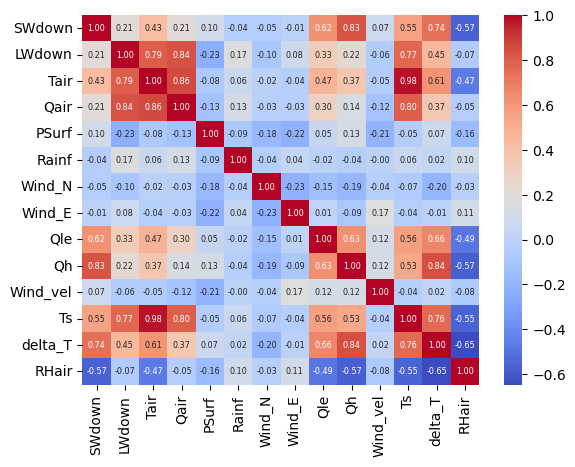

In [84]:
%matplotlib inline
sns.heatmap (df4ml.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 'xx-small'})

In [6]:
class BootstrapCV:
    
    def __init__(self, n_splits, sample_size, random_state = 42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.sample_size = sample_size

    def split(self, X, y=None, groups=None):
        np.random.seed (self.random_state)
        for i in range(self.n_splits):
            sample_indices = np.random.randint(0,X.shape[0], self.sample_size)
            oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
            yield sample_indices, oob_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [91]:
target = 'Qle'
X = df4ml.drop (columns=['Qh', 'Qle'])
Y = df4ml[target]

models = [LinearRegression (), 
          KNeighborsRegressor (),
          RandomForestRegressor (),
          GradientBoostingRegressor (), 
          SVR()] 

cv = BootstrapCV (n_splits=20, sample_size=int (Y.shape[0]*0.95), random_state = 42)

normalization = True

scores = {}

for model in tqdm(models):

    model_pp = Pipeline([
                        ('scaler', StandardScaler(with_mean=normalization, with_std=normalization)),
                        ('regressor', TransformedTargetRegressor(regressor=model, transformer=StandardScaler(with_mean=normalization, with_std=normalization)))
                        ])

    scores4model = cross_validate(model_pp, X, Y, cv=cv, n_jobs=8,
                                  scoring=['r2', 'neg_root_mean_squared_error'], return_train_score = True, return_estimator=True, return_indices=True)

    scores4model['train_idx'] = scores4model['indices']['train']
    scores4model['test_idx'] = scores4model['indices']['test']
    scores4model.pop('indices')
    
    scores4model['model'] = model.__class__.__name__
    scores[model.__class__.__name__] = scores4model


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


In [92]:
scores_df = pd.concat ([pd.DataFrame(scores[model]) for model in scores.keys()], ignore_index=True)

scores_df['test_rmse'] = -scores_df['test_neg_root_mean_squared_error']
scores_df['train_rmse'] = -scores_df['train_neg_root_mean_squared_error']

scores_df.head()



,fit_time,score_time,estimator,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,train_idx,test_idx,model,test_rmse,train_rmse
0,0.028501,0.003533,"(StandardScaler(), TransformedTargetRegressor(...",0.494710,0.514896,-20.785645,-20.836040,"[860, 1294, 1130, 1095, 1638, 2169, 466, 1238,...","[0, 6, 7, 8, 12, 14, 17, 23, 25, 26, 29, 30, 3...",LinearRegression,20.785645,20.836040
1,0.038299,0.002131,"(StandardScaler(), TransformedTargetRegressor(...",0.500839,0.528362,-20.584990,-20.423468,"[1775, 1070, 2010, 398, 1733, 1582, 2125, 2171...","[1, 3, 4, 8, 11, 13, 14, 15, 16, 17, 19, 20, 2...",LinearRegression,20.584990,20.423468
2,0.055319,0.001503,"(StandardScaler(), TransformedTargetRegressor(...",0.502110,0.502094,-20.842440,-20.482710,"[2966, 2053, 287, 1641, 1447, 1913, 607, 456, ...","[0, 2, 3, 5, 6, 8, 9, 10, 12, 14, 17, 19, 20, ...",LinearRegression,20.842440,20.482710
3,0.051816,0.001503,"(StandardScaler(), TransformedTargetRegressor(...",0.485695,0.498037,-20.839558,-21.099392,"[1633, 824, 2926, 1352, 280, 1298, 772, 2890, ...","[0, 1, 4, 5, 7, 8, 14, 15, 19, 24, 25, 26, 27,...",LinearRegression,20.839558,21.099392
4,0.028501,0.002537,"(StandardScaler(), TransformedTargetRegressor(...",0.499684,0.518686,-21.462000,-19.650330,"[2372, 1892, 1694, 1883, 1371, 797, 17, 43, 15...","[1, 3, 4, 5, 8, 9, 13, 14, 16, 19, 21, 22, 27,...",LinearRegression,21.462000,19.650330


### Сравним значимость признаков для отдельных реализаций моделей

c:\Anaconda\envs\ML\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


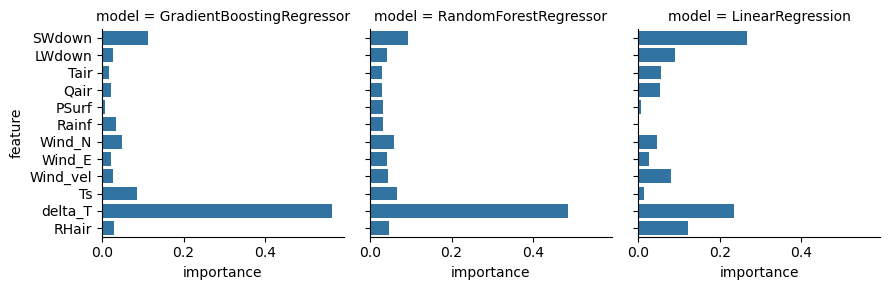

In [93]:
%matplotlib inline

imp_gbr = pd.DataFrame ({'importance': scores_df[scores_df['model'] == 'GradientBoostingRegressor'].iloc[0]['estimator']['regressor'].regressor_.feature_importances_,
                        'model': 'GradientBoostingRegressor', 'feature': X.columns})
imp_rfr = pd.DataFrame ({'importance': scores_df[scores_df['model'] == 'RandomForestRegressor'].iloc[0]['estimator']['regressor'].regressor_.feature_importances_,
                        'model': 'RandomForestRegressor', 'feature': X.columns})
imp_lr = pd.DataFrame ({'importance': scores_df[scores_df['model'] == 'LinearRegression'].iloc[0]['estimator']['regressor'].regressor_.coef_,
                        'model': 'LinearRegression', 'feature': X.columns})

imp_lr['importance'] = np.abs(imp_lr['importance']) / np.sum(np.abs(imp_lr['importance']))

imp = pd.concat([imp_gbr, imp_rfr, imp_lr], axis=0)

g = sns.FacetGrid (imp, col = 'model')
g.map (sns.barplot, 'importance', 'feature')


## Считаем заново прогнозные значения целевой переменной для тестовой и тренировочной выборок
### (и здесь же собираем вместе данные по важности предикторов для всех реализаций)

Это нужно, так как сross_validate их не возвращает, а мы хотим построить диаграмму рассеяния. Записываем их в один большой DataFrame.

In [94]:
reg_results = []
feature_importance = []

for i in scores_df.index:
    train_idx = scores_df.loc[i, 'train_idx']
    test_idx =  scores_df.loc[i, 'test_idx']
    
    cur_Y_train = Y.iloc[train_idx]
    cur_Y_test  = Y.iloc[test_idx]

    cur_X_train = X.iloc[train_idx]
    cur_X_test  = X.iloc[test_idx]

    cur_Y_train_pred = scores_df.loc[i, 'estimator'].predict(cur_X_train)
    cur_Y_test_pred  = scores_df.loc[i, 'estimator'].predict(cur_X_test)

    if hasattr(scores_df.loc[i, 'estimator']['regressor'].regressor_, 'feature_importances_'):
        importance = scores_df.loc[i, 'estimator']['regressor'].regressor_.feature_importances_
    elif hasattr(scores_df.loc[i, 'estimator']['regressor'].regressor_, 'coef_'):
        importance = scores_df.loc[i, 'estimator']['regressor'].regressor_.coef_
        importance = np.abs(importance) / np.sum(np.abs(importance))
    else:
        importance = None

    if importance is not None:
        feature_importance.append(pd.DataFrame({'importance': importance, 'model': scores_df['model'][i], 'feature': X.columns}))   

    reg_results.append (pd.DataFrame({'Y':cur_Y_train, 'Y_pred':cur_Y_train_pred, 'model': scores_df.loc[i,'model'], 'type': 'train'}))
    reg_results.append (pd.DataFrame({'Y':cur_Y_test,  'Y_pred':cur_Y_test_pred,  'model': scores_df.loc[i,'model'], 'type': 'test'}))
    
reg_results = pd.concat(reg_results)

feature_importance = pd.concat(feature_importance)

### Сравним значимость признаков для ансамбля моделей с учетом неопределенности

c:\Anaconda\envs\ML\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


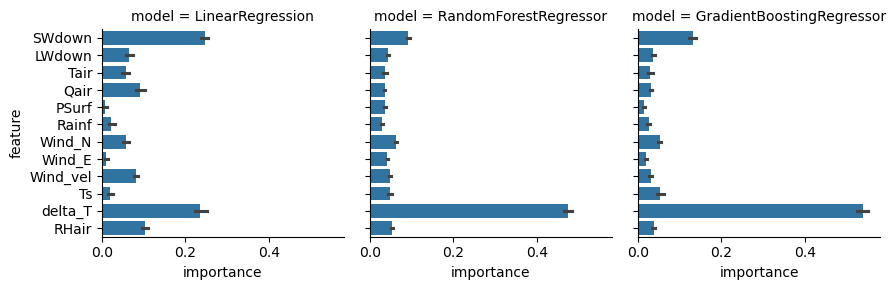

In [95]:
g = sns.FacetGrid (feature_importance, col = 'model')
g.map (sns.barplot, 'importance', 'feature')

### Применим метод permutation_importance

In [96]:
from sklearn.inspection import permutation_importance

feature_importance = []

for i in tqdm (scores_df.index):
    cur_Y_test  = Y.iloc[scores_df.loc[i, 'test_idx']]
    cur_X_test  = X.iloc[scores_df.loc[i, 'test_idx']]

    result = permutation_importance(scores_df.loc[i, 'estimator'], cur_X_test, cur_Y_test, n_repeats=5,
                                    random_state=0, n_jobs = 8, scoring='neg_root_mean_squared_error')

    feature_importance.append(pd.DataFrame({'importance': result['importances_mean']/np.sum(result['importances_mean']),
                                            'model': scores_df['model'][i], 'feature': X.columns}))   

feature_importance = pd.concat(feature_importance)

100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


c:\Anaconda\envs\ML\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


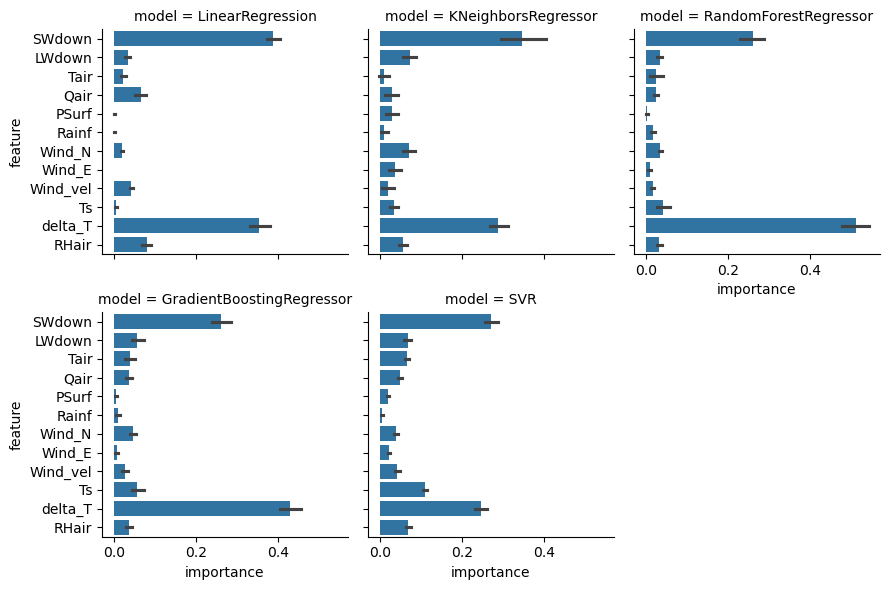

In [99]:
g = sns.FacetGrid (feature_importance, col = 'model', col_wrap=3)
g.map (sns.barplot, 'importance', 'feature')

### Построим диаграммы рассеяния по всем тестовым bootstrap-выборкам

<Figure size 640x480 with 0 Axes>

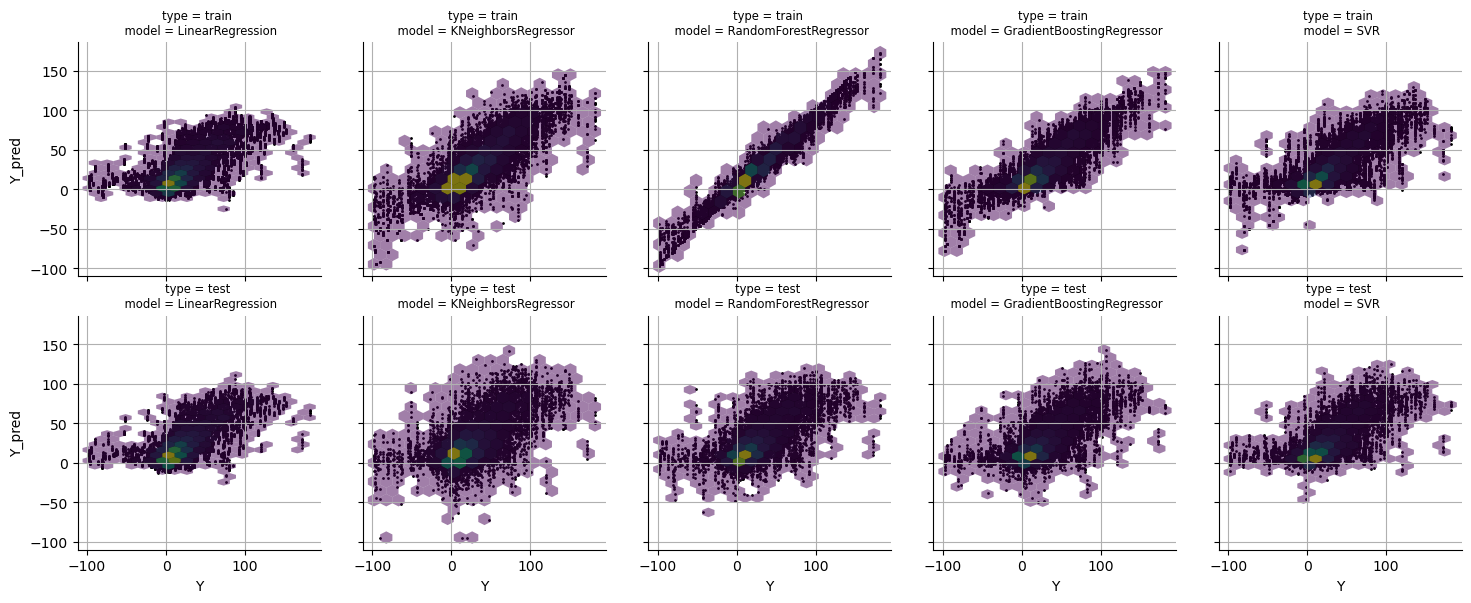

In [100]:
def myhexbin(*args, **kwargs):
        kwargs.pop("color", None)
        hb = plt.hexbin(*args, **kwargs)
        return hb

plt.figure()
g = sns.FacetGrid (reg_results, col = 'model', row='type')
g.map(plt.scatter, 'Y', 'Y_pred', s=1, color = 'black') 
g.map(myhexbin, 'Y', 'Y_pred', mincnt=1, gridsize=18, alpha = 0.5, edgecolor = None) 

for ax in g.axes.flatten():
        ax.set_title(ax.title.get_text().replace('|', '\n'), fontsize='small')
        ax.set_aspect(1) #'equal')
        ax.grid(zorder=0)



## Посмотрим на метрики качества и их неопределенность для разных bootstrap-выборок. 

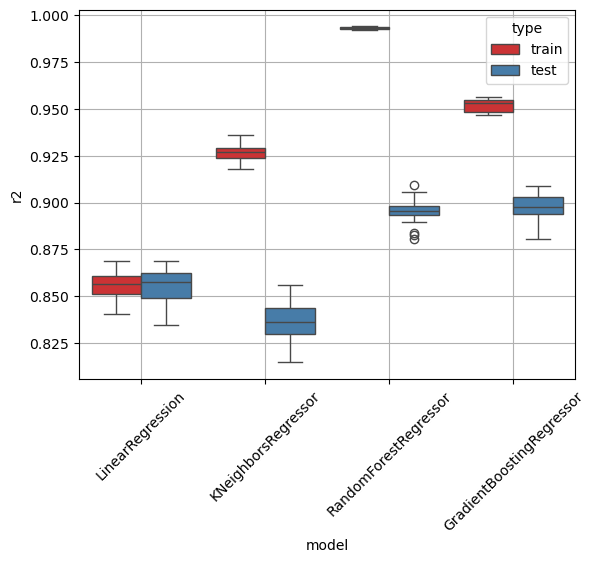

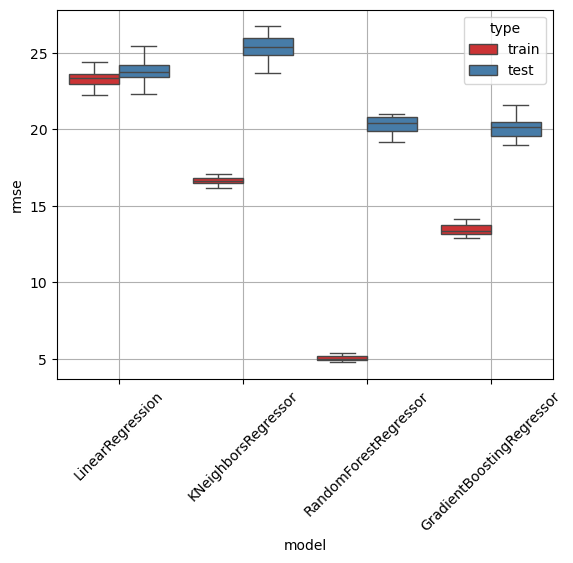

In [46]:

for metric in ['r2', 'rmse']:
    df1 = scores_df[['model', 'train_' + metric]].rename(columns={'train_' + metric: metric,})
    df2 = scores_df[['model', 'test_' + metric]].rename(columns={'test_' + metric: metric,})

    df1['type'] = 'train'
    df2['type'] = 'test'
    df2boxplot = pd.concat([df1, df2])

    plt.figure()
    sns.boxplot (df2boxplot, x='model', y=metric, hue='type', palette='Set1')
    _ = plt.xticks(rotation=45)
    plt.grid()

